## 金融风控项目
在此项目中，你需要完成金融风控模型的搭建。 基于一个用户的基本信息、历史信息来预测逾期与否。采样的具体数据是拍拍贷数据。https://www.kesci.com/home/competition/56cd5f02b89b5bd026cb39c9/content/1
在此数据中提供了三种不同类型的数据:
1. Master: 用户的主要信息
2. Loginfo: 登录信息
3. Userupdateinfo: 修改信息

在本次项目中，我们只使用```Master```的信息来预测一个用户是否会逾期。 数据里有一个字段叫作```Target```是样本的标签（label)。 在```Master```表格里，包含200多个特征，但不少特征具有缺失值。 做项目的时候需要仔细处理一下。 

对于特征处理方面的技术，请参考本章视频课程里的内容。

本项目区别于之前的项目，希望大家能够开放性地思考，不要太局限于给定的条条框框，把目前为止学到的知识都用起来。所以在项目的设计上区别于之前的，没有设置太多的框架性的，大家可以按照自己的思路灵活做项目。 由于项目本身来自于数据竞赛，所以可以试着跟竞赛里的TOP选手的结果做一下对比，看看跟他们的差距或者优势在哪儿。

```数据```
- ```Training/PPD_Training_Master_GBK_3_1_Training_Set.csv```:  训练数据
- ```Test/PPD_Master_GBK_2_Test_Set.csv```: 测试数据


强调：一定要把注释写清楚。 每个函数，每一个模块具体做什么写清楚。

> 注意： 除了下面导入的库，还有sklearn、XGBoost等经典的库之外，建议不要使用其他的函数库。 如果你不得不使用一些其他特殊的库，请把环境注明在requirements.txt里面，不然我们判作业的时候就没有办法去评判了。 

Master
每一行代表一个样本（一笔成功成交借款），每个样本包含200多个各类字段。

- idx：每一笔贷款的unique key，可以与另外2个文件里的idx相匹配。

- UserInfo_*：借款人特征字段

- WeblogInfo_*：Info网络行为字段

- Education_Info*：学历学籍字段

- ThirdParty_Info_PeriodN_*：第三方数据时间段N字段

- SocialNetwork_*：社交网络字段

- LinstingInfo：借款成交时间

- Target：违约标签（1 = 贷款违约，0 = 正常还款）。测试集里不包含target字段。

 



In [20]:
import numpy as np 
import math 
import pandas as pd 
pd.set_option('display.float_format',lambda x:'%.3f' % x)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import os 


In [46]:
# 读取Master数据
train = pd.read_csv('data/Training/PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding='gb18030')
test = pd.read_csv('data/Test/PPD_Master_GBK_2_Test_Set.csv',encoding='gb18030')
data=pd.concat([train,test],sort=False)
print(train.shape,test.shape)
print("data shape:",data.shape)

(30000, 228) (19999, 227)
data shape: (49999, 228)


In [49]:
train_size=len(train)
test_size=len(test)

In [50]:
# 展示记录
data.head()

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,...,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,target,ListingInfo
0,10001,1.000,深圳,4.000,深圳,nan,1.000,nan,1.000,1.000,...,222,-1,0,0,0,0,0,1,0.000,2014/3/5
1,10002,1.000,温州,4.000,温州,nan,0.000,nan,1.000,1.000,...,1,-1,0,0,0,0,0,2,0.000,2014/2/26
2,10003,1.000,宜昌,3.000,宜昌,nan,0.000,nan,2.000,2.000,...,-1,-1,-1,1,0,0,0,0,0.000,2014/2/28
3,10006,4.000,南平,1.000,南平,nan,nan,nan,nan,nan,...,-1,-1,-1,0,0,0,0,0,0.000,2014/2/25
4,10007,5.000,辽阳,1.000,辽阳,nan,0.000,nan,1.000,1.000,...,-1,-1,-1,0,0,0,0,0,0.000,2014/2/27


In [51]:
# 正负样本的比例， 可以看出样本比例不平衡的
data[:train_size].target.value_counts() # 10：1

0.000    27802
1.000     2198
Name: target, dtype: int64

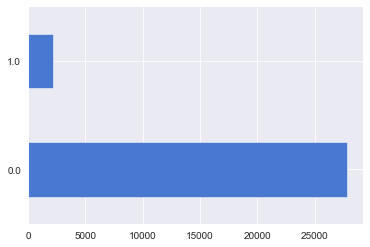

In [52]:
data[:train_size].target.value_counts().plot(kind='barh')
plt.show()

In [53]:
data.describe()

,Idx,UserInfo_1,UserInfo_3,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,...,SocialNetwork_9,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,target
count,49999.000,49988.000,49987.000,1624.000,47195.000,1624.000,47204.000,47204.000,47204.000,49999.000,...,49999.000,49999.000,49999.000,49999.000,49999.000,49999.000,49999.000,49999.000,49999.000,30000.000
mean,46098.523,3.218,4.694,2.123,0.133,1.236,3.048,1.834,2.967,10.640,...,34.650,73.081,-0.992,-0.745,0.220,0.062,0.028,0.017,0.254,0.073
std,26583.818,1.833,1.320,7.820,0.361,7.778,3.759,1.779,3.717,16.001,...,130.898,714.111,1.651,0.441,0.421,0.242,0.165,0.129,0.437,0.261
min,3.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,0.000,...,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,22728.500,1.000,4.000,1.000,0.000,0.000,1.000,1.000,1.000,2.000,...,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,46490.000,3.000,5.000,1.000,0.000,0.000,2.000,1.000,2.000,6.000,...,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,69080.500,5.000,5.000,1.000,0.000,1.000,3.000,2.000,3.000,13.000,...,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
max,91704.000,7.000,7.000,133.000,4.000,133.000,165.000,122.000,165.000,722.000,...,3242.000,72042.000,368.000,1.000,4.000,3.000,1.000,1.000,3.000,1.000


好了，剩下的部分需要由大家完成。 我大致给一下思路，然后大家可以按照这个思路去一步步完成。 

In [54]:
def statics(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values',
                                            'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=False, inplace=True)
    return stats_df

In [55]:
stats_df=statics(data)
stats_df

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
7,WeblogInfo_3,23,96.752,96.752,float64
5,WeblogInfo_1,24,96.752,96.752,float64
30,UserInfo_12,2,63.211,63.211,float64
31,UserInfo_13,2,63.211,63.211,float64
29,UserInfo_11,2,63.211,63.211,float64
226,target,2,39.999,55.605,float64
52,WeblogInfo_20,38,26.709,37.151,object
53,WeblogInfo_21,4,10.112,72.149,object
51,WeblogInfo_19,7,9.786,73.123,object
6,WeblogInfo_2,5,5.608,82.442,float64


> #### 1. 数据的预处。 需要考虑以下几个方面：
- ```缺失值```。数据里有大量的缺失值，需要做一些处理。 
- ```字符串的清洗```。比如“北京市”和“北京”合并成“北京”， 统一转换成小写等
- ```二值化```。具体方法请参考课程里的介绍
- ```衍生特征```：比如户籍地和当前城市是否是同一个？ 
- ```特征的独热编码```：对于类别型特征使用独热编码形式
- ```连续性特征的处理```：根据情况来处理
- ```其他```: 根据情况，自行决定要不要做

In [56]:
## 缺失值删除
# WeblogInfo_3，WeblogInfo_1
data=data.drop(columns=['WeblogInfo_3','WeblogInfo_1'])
data.shape

(49999, 226)

In [7]:
## 缺失值填充
data=data.fillna(-999)

In [8]:
data.shape[0]-data.count() # 每一列缺失值的个数

Idx                           0
UserInfo_1                    0
UserInfo_2                    0
UserInfo_3                    0
UserInfo_4                    0
WeblogInfo_1                  0
WeblogInfo_2                  0
WeblogInfo_3                  0
WeblogInfo_4                  0
WeblogInfo_5                  0
WeblogInfo_6                  0
WeblogInfo_7                  0
WeblogInfo_8                  0
WeblogInfo_9                  0
WeblogInfo_10                 0
WeblogInfo_11                 0
WeblogInfo_12                 0
WeblogInfo_13                 0
WeblogInfo_14                 0
WeblogInfo_15                 0
WeblogInfo_16                 0
WeblogInfo_17                 0
WeblogInfo_18                 0
UserInfo_5                    0
UserInfo_6                    0
UserInfo_7                    0
UserInfo_8                    0
UserInfo_9                    0
UserInfo_10                   0
UserInfo_11                   0
                             ..
ThirdPar

In [32]:
## 字符串清洗
# UserInfo_2
# UserInfo_4
data['UserInfo_2']=data['UserInfo_2'].astype(str) # -999->'-999'
data['UserInfo_4']=data['UserInfo_4'].astype(str)

data['UserInfo_2']=data['UserInfo_2'].apply(lambda x:x.rstrip('市'))
data['UserInfo_4']=data['UserInfo_4'].apply(lambda x:x.rstrip('市'))

In [62]:
# 二值化特征处理
# nunique==2
bin_cols=[]
for col in data.columns:
    if col not in ['Idx','target']:
        if data[col].nunique()==2:
            bin_cols.append(col)
bin_cols

['UserInfo_11',
 'UserInfo_12',
 'UserInfo_13',
 'UserInfo_17',
 'UserInfo_21',
 'Education_Info1',
 'Education_Info5',
 'Education_Info7',
 'WeblogInfo_41',
 'WeblogInfo_44',
 'SocialNetwork_15',
 'SocialNetwork_16']

In [63]:
data=pd.get_dummies(data,columns=bin_cols)
data.shape

(49999, 238)

In [64]:
## 类别编码
from sklearn.preprocessing import LabelEncoder

In [65]:
lbl = LabelEncoder()
object_col = [i for i in data.select_dtypes(object).columns if i not in ['Idx','target']]
for i in object_col:
    print(i)
    data[i] = lbl.fit_transform(data[i].astype(str))

UserInfo_2
UserInfo_4
UserInfo_7
UserInfo_8
UserInfo_9
UserInfo_19
UserInfo_20
UserInfo_22
UserInfo_23
UserInfo_24
Education_Info2
Education_Info3
Education_Info4
Education_Info6
Education_Info8
WeblogInfo_19
WeblogInfo_20
WeblogInfo_21
ListingInfo


> #### 2. 特征选择
200多个特征里可能有效的特征不会很多。在这里做特征选择相关的工作。 在特征选择这一块请使用```树```模型。 比如sklearn自带的特征选择模块（https://scikit-learn.org/stable/modules/feature_selection.html）， 或者直接使用XGBoost等模型来直接选择。 这些模型训练好之后你可以直接通过```feature_importance_values```属性来获取。

In [66]:
no_feas=['Idx','target']
features=[fea for fea in data.columns if fea not in no_feas]
features[:10]

['UserInfo_1',
 'UserInfo_2',
 'UserInfo_3',
 'UserInfo_4',
 'WeblogInfo_2',
 'WeblogInfo_4',
 'WeblogInfo_5',
 'WeblogInfo_6',
 'WeblogInfo_7',
 'WeblogInfo_8']

In [67]:
print(len(features))

236


In [68]:
train,test=data[:train_size],data[train_size:]
print("(train.shape,test.shape:",train.shape,test.shape)

(train.shape,test.shape: (30000, 238) (19999, 238)


> #### 3. XGBoost来训练风控模型，结果以AUC为准
https://github.com/dmlc/xgboost   这是XGBoost library具体的地址, 具有详细的文档。 https://pypi.org/project/xgboost/ 里有安装的步骤。 试着去调一下它的超参数，使得得到最好的效果。 一定要注意不需要使用测试数据来训练。 最终的结果以测试数据上的AUC为标准。 

In [69]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm

n_fold = 5
y_scores = 0

y_test_pred=np.zeros(test_size) # 暂存5折测试集预测结果
fea_importances = np.zeros(len(features)) # 特征重要性

label = ['target']
train[label] = train[label].astype(int)


def pred(X_test, model, batch_size=10000):
    iterations = (X_test.shape[0] + batch_size - 1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(test_size)
    print(f'predicting {i}-th model')
    for k in tqdm(range(iterations)):
        y_pred_test = model.predict_proba(X_test[k * batch_size:(k + 1) * batch_size])[:, 1]
        y_test_pred_total[k * batch_size:(k + 1) * batch_size] += y_pred_test
    return y_test_pred_total


# [1314, 4590]
kfold = StratifiedKFold(n_splits=n_fold, shuffle=False, random_state=1314)
for i, (train_index, valid_index) in enumerate(kfold.split(train[features], train[label])):
    print("n。{}_th fold".format(i))
    X_train, y_train, X_valid, y_valid = train.loc[train_index][features], train[label].loc[train_index], \
                                         train.loc[valid_index][features], train[label].loc[valid_index]
    bst = xgb.XGBClassifier(learning_rate=0.1,
                            n_estimators=1000,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective='binary:logistic',
                            nthread=20,
                            scale_pos_weight=1,
                            seed=2
                            )
    bst.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=['logloss', 'auc'],
            verbose=True,
            early_stopping_rounds=10)
    valid_pred = bst.predict_proba(X_valid)[:, 1]
    # print("accuracy:",accuracy_score(y_valid, valid_pred))
    print("acu score:", roc_auc_score(y_valid, valid_pred))
    y_scores += bst.best_score
    
    # 预测结果
    y_test_pred+=bst.predict_proba(test[features])[:, 1]
    fea_importances += bst.feature_importances_
    del bst
    del valid_pred
    gc.collect()


fea_importance_df = pd.DataFrame({
    'features': features,
    'importance': fea_importances
})
fea_importance_df.sort_values(by="importance", ascending=False)


n。0_th fold
[0]	validation_0-logloss:0.624876	validation_0-auc:0.626465
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.568287	validation_0-auc:0.630395
[2]	validation_0-logloss:0.52124	validation_0-auc:0.651393
[3]	validation_0-logloss:0.482461	validation_0-auc:0.666202
[4]	validation_0-logloss:0.449451	validation_0-auc:0.673682
[5]	validation_0-logloss:0.421664	validation_0-auc:0.672585
[6]	validation_0-logloss:0.398132	validation_0-auc:0.668288
[7]	validation_0-logloss:0.377599	validation_0-auc:0.66867
[8]	validation_0-logloss:0.359905	validation_0-auc:0.669214
[9]	validation_0-logloss:0.344441	validation_0-auc:0.67256
[10]	validation_0-logloss:0.331339	validation_0-auc:0.672357
[11]	validation_0-logloss:0.322309	validation_0-auc:0.671436
[12]	validation_0-logloss:0.312199	validation_0-auc:0.672106
[13]	validation_0-logloss:0.303178	validation_0-auc

[12]	validation_0-logloss:0.312002	validation_0-auc:0.635436
[13]	validation_0-logloss:0.3041	validation_0-auc:0.636767
[14]	validation_0-logloss:0.297106	validation_0-auc:0.641805
[15]	validation_0-logloss:0.290998	validation_0-auc:0.647037
[16]	validation_0-logloss:0.285399	validation_0-auc:0.647333
[17]	validation_0-logloss:0.281024	validation_0-auc:0.646679
[18]	validation_0-logloss:0.276272	validation_0-auc:0.653262
[19]	validation_0-logloss:0.272679	validation_0-auc:0.65278
[20]	validation_0-logloss:0.270561	validation_0-auc:0.649762
[21]	validation_0-logloss:0.267926	validation_0-auc:0.650889
[22]	validation_0-logloss:0.265525	validation_0-auc:0.655444
[23]	validation_0-logloss:0.262827	validation_0-auc:0.660412
[24]	validation_0-logloss:0.261517	validation_0-auc:0.660019
[25]	validation_0-logloss:0.259171	validation_0-auc:0.665414
[26]	validation_0-logloss:0.25789	validation_0-auc:0.666187
[27]	validation_0-logloss:0.256543	validation_0-auc:0.666761
[28]	validation_0-logloss:0.

[147]	validation_0-logloss:0.248689	validation_0-auc:0.72483
[148]	validation_0-logloss:0.249112	validation_0-auc:0.723286
[149]	validation_0-logloss:0.248885	validation_0-auc:0.724383
[150]	validation_0-logloss:0.248888	validation_0-auc:0.724292
[151]	validation_0-logloss:0.249202	validation_0-auc:0.723458
[152]	validation_0-logloss:0.249426	validation_0-auc:0.722977
[153]	validation_0-logloss:0.249434	validation_0-auc:0.72292
Stopping. Best iteration:
[143]	validation_0-logloss:0.248426	validation_0-auc:0.725669

acu score: 0.7256694416676226


,features,importance
82,ThirdParty_Info_Period1_6,0.079
211,ListingInfo,0.074
145,ThirdParty_Info_Period5_1,0.074
99,ThirdParty_Info_Period2_6,0.069
162,ThirdParty_Info_Period6_1,0.062
108,ThirdParty_Info_Period2_15,0.060
7,WeblogInfo_6,0.059
218,UserInfo_17_1,0.056
26,UserInfo_14,0.053
27,UserInfo_15,0.053


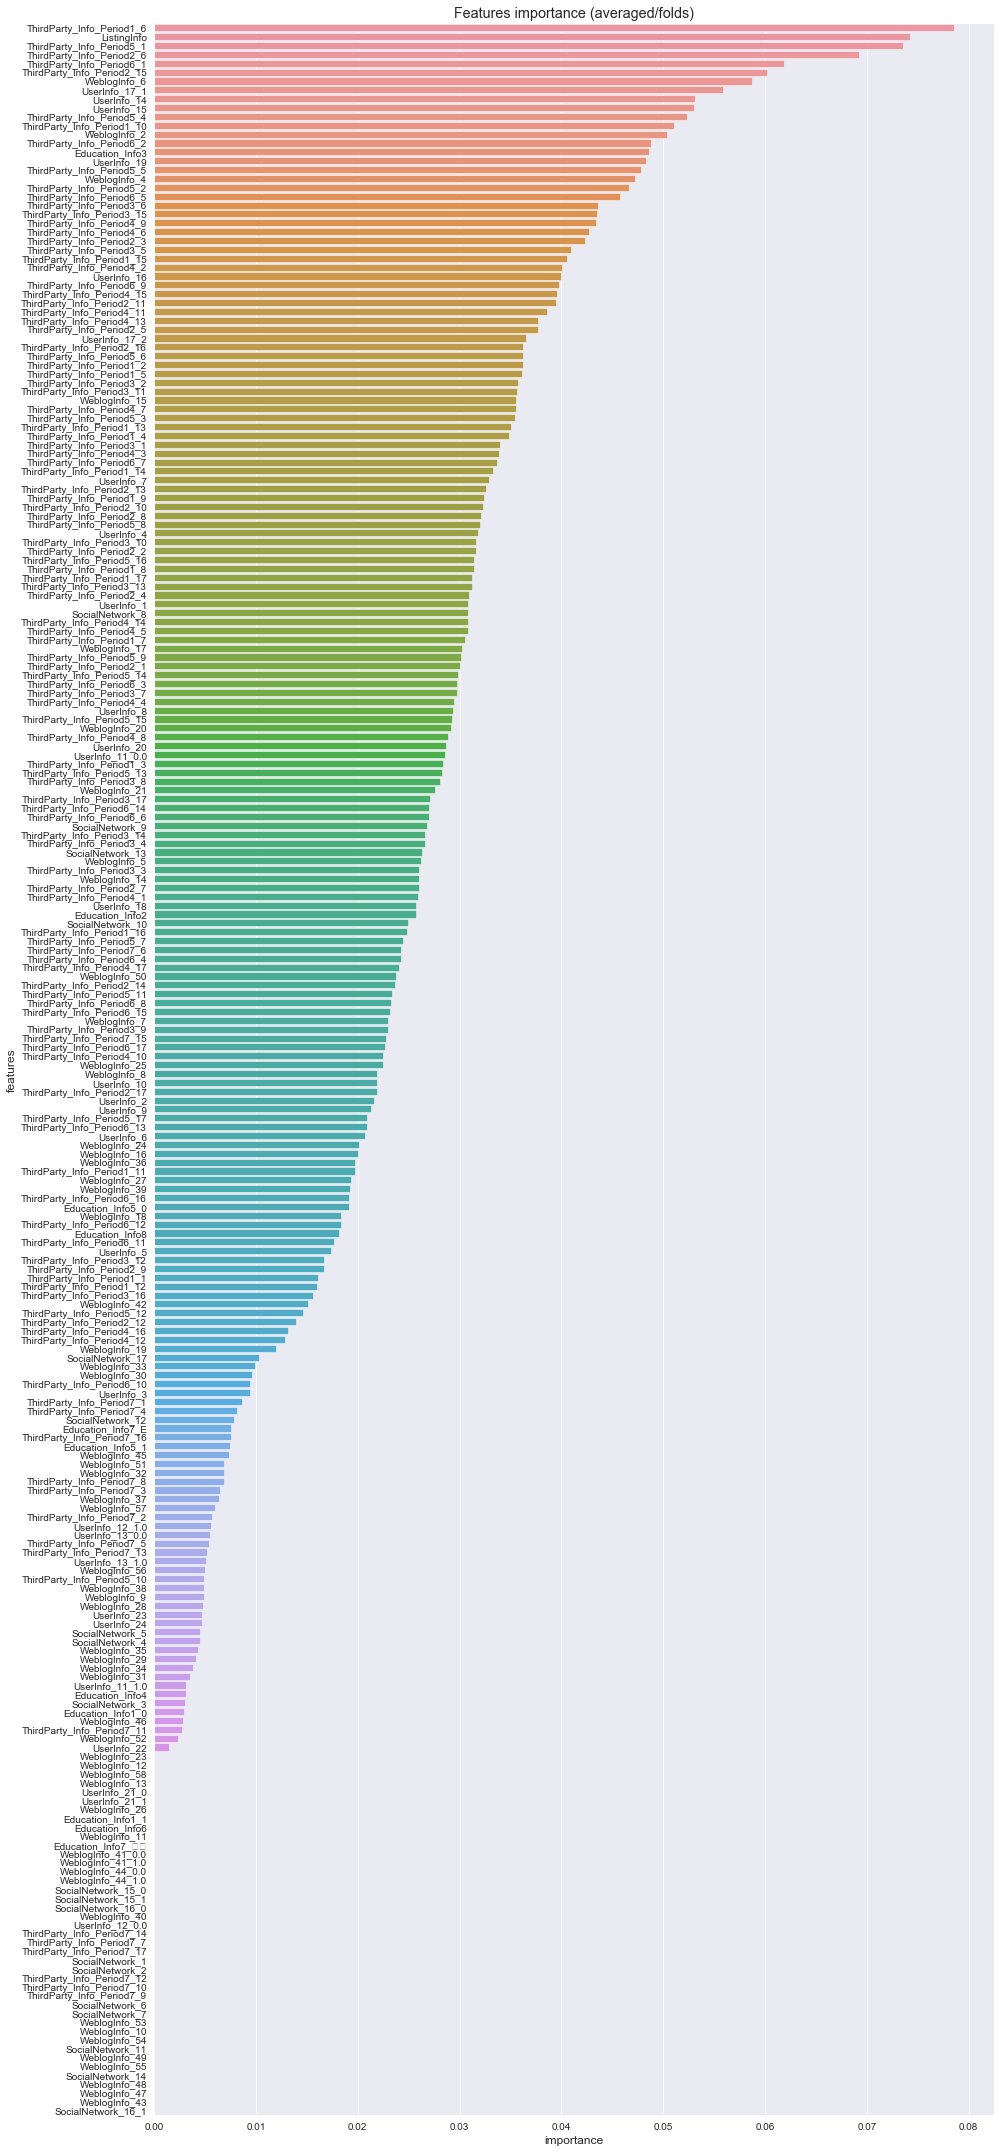

In [70]:
plt.figure(figsize=(14, 30))
sns.barplot(x="importance", y="features", data=fea_importance_df.sort_values(by="importance", ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.show()

In [75]:
y_test_pred/=kfold.n_splits
y_test_pred

array([0.16468702, 0.18587318, 0.23473295, ..., 0.17067541, 0.16146865,
       0.15338568])

In [ ]:
# https://www.kesci.com/home/competition/56cd5f02b89b5bd026cb39c9/works
# https://www.dcjingsai.com/common/cmpt/2019%E5%8E%A6%E9%97%A8%E5%9B%BD%E9%99%85%E9%93%B6%E8%A1%8C%E2%80%9C%E6%95%B0%E5%88%9B%E9%87%91%E8%9E%8D%E6%9D%AF%E2%80%9D%E6%95%B0%E6%8D%AE%E5%BB%BA%E6%A8%A1%E5%A4%A7%E8%B5%9B_%E8%B5%9B%E4%BD%93%E4%B8%8E%E6%95%B0%E6%8D%AE.html

In [ ]:
#!/usr/bin/env python  
# -*- coding:utf-8 _*-  
""" 
@author:quincyqiang 
@license: Apache Licence 
@file: 17_stacking.py 
@time: 2019-11-09 22:42
@description:
"""
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from gen_feas import load_data

train, test, no_features, features = load_data()

X_train = train[features].values
y_train = train['target']
target = y_train
X_test = test[features].values

## lgb
param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,  # 0.05
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=200,
                    early_stopping_rounds=100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)

    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))


##### xgb
# xgb_params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.02, 'max_depth': 4, 'min_child_weight': 6,
#               'colsample_bytree': 0.7, 'subsample': 0.7, 'silent': 1, 'eval_metric': ['auc']}
#
# folds = KFold(n_splits=5, shuffle=True, random_state=2018)
# oof_xgb = np.zeros(len(train))
# predictions_xgb = np.zeros(len(test))
#
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
#     print("fold n°{}".format(fold_ + 1))
#     trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
#     val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
#
#     watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
#     clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
#                     verbose_eval=100, params=xgb_params)
#     oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
#     predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
#
# print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))
def load_xgb_data():
    train = pd.read_csv("new_data/train.csv")
    train_target = pd.read_csv('new_data/train_target.csv')
    train = train.merge(train_target, on='id')
    test = pd.read_csv("new_data/test.csv")
    test['target'] = -1
    df = pd.concat([train, test], sort=False, axis=0)

    # 删除重复列
    duplicated_features = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6',
                           'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_13',
                           'x_15', 'x_17', 'x_18', 'x_19', 'x_21',
                           'x_23', 'x_24', 'x_36', 'x_37', 'x_38', 'x_57', 'x_58',
                           'x_59', 'x_60', 'x_77', 'x_78'] + \
                          ['x_22', 'x_40', 'x_70'] + \
                          ['x_41'] + \
                          ['x_43'] + \
                          ['x_45'] + \
                          ['x_61']

    # df = df.drop(columns=duplicated_features)
    ###############
    ###############

    x_feature = []
    for i in range(79):
        x_feature.append('x_{}'.format(i))

    no_features = ['id', 'target', 'isNew']
    features = []
    numerical_features = ['lmt', 'certValidBegin', 'certValidStop']
    categorical_features = [fea for fea in df.columns if fea not in numerical_features + no_features]

    ###########
    import time

    df['certValidPeriod'] = df['certValidStop'] - df['certValidBegin']
    df['begin'] = df['certValidBegin'].apply(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x)))
    df['end'] = df['certValidStop'].apply(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x)))
    df['begin'] = df['begin'].apply(lambda x: int(x.split('-')[0]))
    df['end'] = df['end'].apply(lambda x: int(x.split('-')[0]))
    df['val_period'] = df['end'] - df['begin']

    ###########
    # 0.76新加
    ###########
    cols = []

    df['certId12'] = df['certId'].apply(lambda x: int(str(x)[:2]) if x != -999 else -999)
    df['certId34'] = df['certId'].apply(lambda x: int(str(x)[2:4]) if x != -999 else -999)
    df['certId56'] = df['certId'].apply(lambda x: int(str(x)[4:]) if x != -999 else -999)

    from sklearn.preprocessing import LabelEncoder

    df['certId12_basicLevel'] = df['certId12'].astype(str) + df['basicLevel'].astype(str)
    df['certId34_basicLevel'] = df['certId34'].astype(str) + df['basicLevel'].astype(str)
    df['certId56_basicLevel'] = df['certId56'].astype(str) + df['basicLevel'].astype(str)

    df['certId12_loanProduct'] = df['certId12'].astype(str) + df['loanProduct'].astype(str)
    df['certId34_loanProduct'] = df['certId34'].astype(str) + df['loanProduct'].astype(str)
    df['certId56_loanProduct'] = df['certId56'].astype(str) + df['loanProduct'].astype(str)

    # cols += ['certId12_loanProduct', 'certId34_loanProduct','certId56_loanProduct']
    cols += ['certId12_basicLevel', 'certId34_basicLevel', 'certId56_basicLevel',
             'certId12_loanProduct', 'certId34_loanProduct', 'certId56_loanProduct']

    df['dist56'] = df['dist'].apply(lambda x: int(str(x)[4:]) if x != -999 else -999)
    df['dist56_basicLevel'] = df['dist56'].astype(str) + df['basicLevel'].astype(str)
    df['dist56_loanProduct'] = df['dist56'].astype(str) + df['loanProduct'].astype(str)
    # cols += ['dist56_loanProduct']
    cols += ['dist56_basicLevel', 'dist56_loanProduct']

    # 估计有用
    # df['residentAddr56'] = df['residentAddr'].apply(lambda x: int(str(x)[4:]) if x != -999 else -999)
    # df['residentAddr56_basicLevel'] = df['residentAddr56'].astype(str) + df['basicLevel'].astype(str)
    # df['residentAddr56_loanProduct'] = df['residentAddr56'].astype(str) + df['loanProduct'].astype(str)
    # cols += ['residentAddr56_loanProduct']
    # cols += ['residentAddr56_basicLevel', 'residentAddr56_loanProduct']
    ####

    # df['certId12_lmt'] = df.groupby('certId12')['lmt'].transform('mean')
    # df['certId12_lmt'] = df.groupby('certId12')['lmt'].transform('median')

    # df['certId34_lmt'] = df.groupby('certId34')['lmt'].transform('mean')
    # df['certId34_lmt'] = df.groupby('certId34')['lmt'].transform('median')

    # df['certId56_lmt'] = df.groupby('certId56')['lmt'].transform('mean')
    # df['certId56_lmt'] = df.groupby('certId56')['lmt'].transform('median')

    ################
    # things not work
    # df['certId12_edu'] = df['certId12'].astype(str) + df['edu'].astype(str)
    # df['certId34_edu'] = df['certId34'].astype(str) + df['edu'].astype(str)
    # df['certId56_edu'] = df['certId56'].astype(str) + df['edu'].astype(str)
    # 'certId12_edu', 'certId34_edu','certId56_edu'

    # useless = ['x_59','x_22','x_23','x_24','x_30','x_31','x_32','x_35','x_36','x_37','x_38','x_39','x_40','x_42',
    #  'x_57','x_58','x_60','x_69','x_70','x_77','x_78','ncloseCreditCard','unpayIndvLoan','unpayOtherLoan',
    #  'unpayNormalLoan','5yearBadloan','x_21','x_19','is_edu_equal','x_9','x_7','x_8','x_4','x_10','x_11',
    #  'x_1','x_6','x_13','x_3','x_18','x_15','x_17','x_2','x_5']
    ################

    # 待尝试
    # 四个一起降分
    # df['certId12_job'] = df['certId12'].astype(str) + df['job'].astype(str)
    # df['certId12_ethnic'] = df['certId12'].astype(str) + df['ethnic'].astype(str)
    # cols += ['certId12_job', 'certId12_ethnic']

    # df['certId12_edu'] = df['certId12'].astype(str) + df['edu'].astype(str)
    # df['certId12_highestEdu'] = df['certId12'].astype(str) + df['highestEdu'].astype(str)
    # cols += ['certId12_edu', 'certId12_highestEdu']

    # df['edu_basicLevel'] = df['edu'].astype(str) + df['basicLevel'].astype(str)
    # df['edu_loanProduct'] = df['edu'].astype(str) + df['loanProduct'].astype(str)
    # df['edu_lmt'] = df.groupby('edu')['lmt'].transform('mean')
    # df['edu_lmt'] = df.groupby('edu')['lmt'].transform('median')
    # cols += ['edu_basicLevel', 'edu_loanProduct']

    # df['highestEdu_basicLevel'] = df['highestEdu'].astype(str) + df['basicLevel'].astype(str)
    # df['highestEdu_loanProduct'] = df['highestEdu'].astype(str) + df['loanProduct'].astype(str)
    # df['highestEdu_lmt'] = df.groupby('highestEdu')['lmt'].transform('mean')
    # df['highestEdu_lmt'] = df.groupby('highestEdu')['lmt'].transform('median')
    # cols += ['highestEdu_basicLevel', 'highestEdu_loanProduct']

    for col in cols:
        lab = LabelEncoder()
        df[col] = lab.fit_transform(df[col])

    cols += ['certId12', 'certId34', 'certId56', 'dist56']

    cols += ['bankCard', 'residentAddr', 'certId', 'dist', 'age', 'job', 'basicLevel', 'loanProduct', 'val_period']
    # count
    for col in cols:
        df['{}_count'.format(col)] = df.groupby(col)['id'].transform('count')

    df['is_edu_equal'] = (df['edu'] == df['highestEdu']).astype(int)

    print(df.shape)

    feature = [fea for fea in df.columns if fea not in no_features + ['begin', 'end']]
    train, test = df[:len(train)], df[len(train):]
    return train, test, feature


train, test, feature = load_xgb_data()

X_train = train[feature].values
y_train = train['target']
target = y_train
X_test = test[feature].values

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, KFold

n_fold = 5
y_scores = 0
y_pred_l1 = np.zeros([n_fold, test.shape[0]])
y_pred_all_l1 = np.zeros(test.shape[0])
fea_importances = np.zeros(len(feature))

label = ['target']
# [1314, 4590]

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1314)
for i, (train_index, valid_index) in enumerate(kfold.split(train[feature], train[label])):
    print(i)
    # X_train, y_train, X_valid, y_valid = train.loc[train_index][feature], train[label].loc[train_index], \
    #                                      train.loc[valid_index][feature], train[label].loc[valid_index]

    bst = xgb.XGBClassifier(max_depth=3, n_estimators=10000, verbosity=1, learning_rate=0.01)
    bst.fit(X_train[train_index], y_train[train_index], eval_set=[(X_train[valid_index], y_train[valid_index])],
            eval_metric='auc', verbose=500,
            early_stopping_rounds=500)
    oof_xgb[valid_index] = bst.predict_proba(X_train[valid_index])[:, 1]

    predictions_xgb += bst.predict_proba(X_test)[:, 1] / folds.n_splits
    fea_importances += bst.feature_importances_

# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb, oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack, target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)

    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10

mean_squared_error(target.values, oof_stack)

from pandas import DataFrame

result = DataFrame()
result['id'] = test['id']
result['target'] = predictions
result.to_csv('result/stacking.csv', index=False, sep=",", float_format='%.6f')
